In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from PIL import Image
warnings.filterwarnings('ignore')

Here is some utility functions that would help us during the EDA:

In [28]:
def get_img_dimensions(img_path):
    with Image.open(img_path) as img:
        return img.size

def rle_to_mask(starts, lengths, height, width):
    # Create an empty array of zeros of shape (height, width)
    mask = np.zeros(height * width, dtype=np.uint8)

    # For each start and length, set the corresponding values in the mask to 1
    for start, length in zip(starts, lengths):
        mask[start:start + length] = 1

    # Reshape the mask into the desired dimensions
    mask = mask.reshape((height, width))
    mask = mask.T
    return mask

def create_mask(mask_array, width, height):
    mask = np.zeros((width, height), dtype=np.int16)
    # if element == element:
    if isinstance(mask_array, str):
        split = mask_array.split()
        startP, lengthP = [np.array(x, dtype=int) for x in (split[::2], split[1::2])]
        mask += rle_to_mask(startP, lengthP, width, height)
    return mask

def calc_mask_size(pixelStr: str):
    if (pixelStr == pixelStr):
        split = pixelStr.split(" ")
        lengthP = np.array(split[1::2], dtype=int)
        return lengthP.sum()
    else:
        return 0


In [29]:
# aka env variables
BASE_DIR = '/kaggle/input/airbus-ship-detection'
TEST_IMG_DIR = os.path.join(BASE_DIR,'test_v2')
TRAIN_IMG_DIR = os.path.join(BASE_DIR,'train_v2')
TRAIN_DATASET_CSV = os.path.join(BASE_DIR,'train_ship_segmentations_v2.csv')
TRAIN_DATASET_WITH_IMAGE_DIMENTIONS = '/kaggle/input/dataset-with-img-dimentions/dataset_with_image_dims'

In [88]:
# read dataset
df = pd.read_csv(TRAIN_DATASET_CSV)
display(df.head(10))


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,NaN
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


Lets display 20 empty images and 20 non-empty to take a quick look at our dataset:

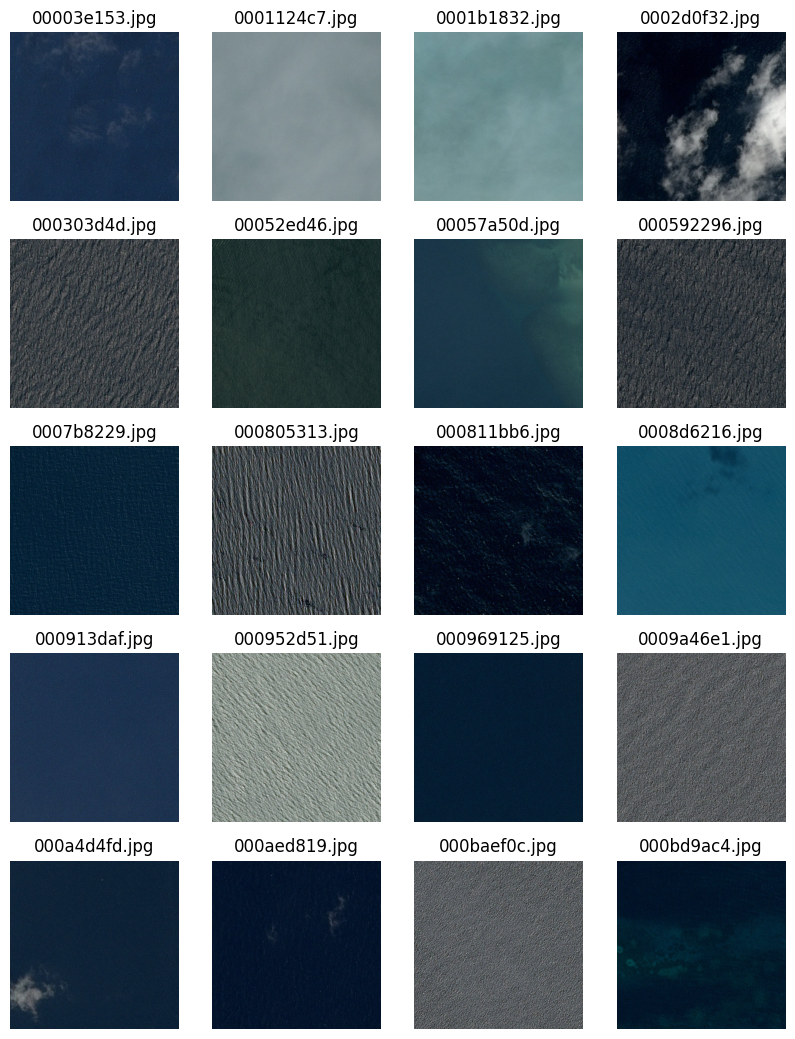

In [112]:
fig, ax = plt.subplots(5,4 , figsize=(10, 13))
imgs_empty = df[df['EncodedPixels'].isna()]
imgs_empty = imgs_empty.head(20)
ax = ax.flatten()
for i in range(len(imgs_empty)):
    img_name = imgs_empty['ImageId'].iloc[i]
    img = Image.open(os.path.join(TRAIN_IMG_DIR, img_name))
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(img_name)


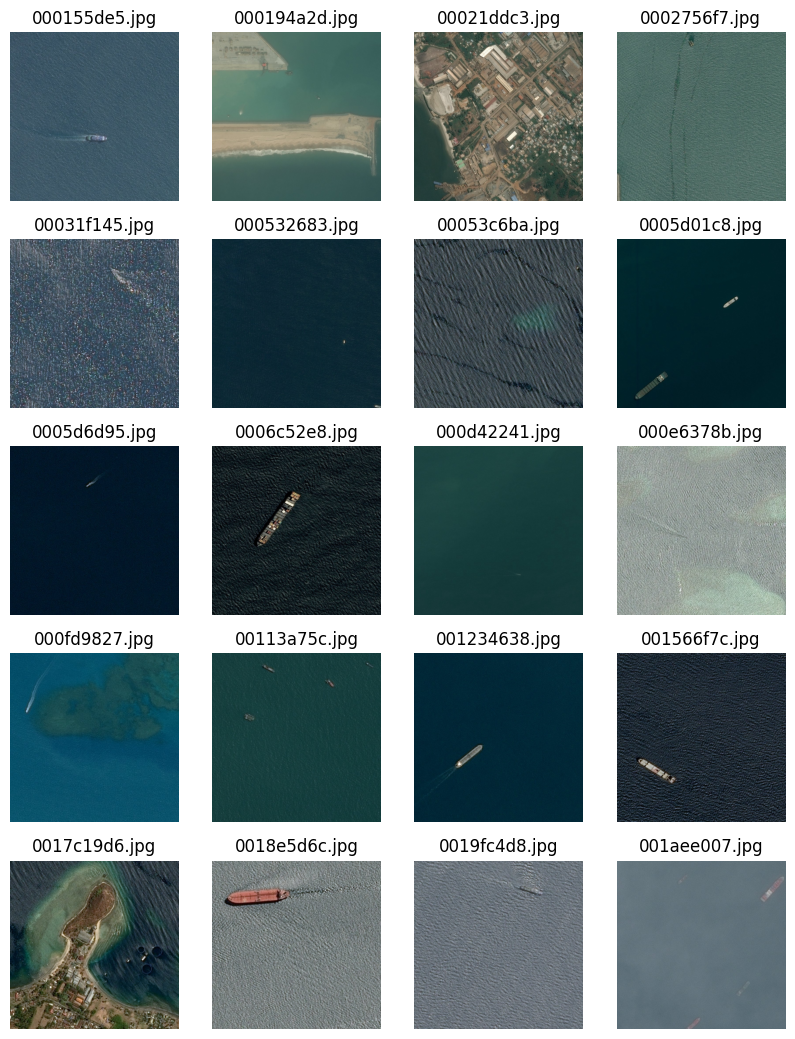

In [113]:
fig, ax = plt.subplots(5,4 , figsize=(10, 13))
imgs_nonempty = df[df['EncodedPixels'].notna()]
imgs_nonempty = imgs_nonempty.drop_duplicates(subset='ImageId').head(20)
ax = ax.flatten()
for i in range(len(imgs_nonempty)):
    img_name = imgs_nonempty['ImageId'].iloc[i]
    img = Image.open(os.path.join(TRAIN_IMG_DIR, img_name))
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(img_name)

We can see that the images show ships in various locations like open water, near the coast, and close to ports or human-made structures. The ships come in different sizes, which might mean the spatial resolution of the images varies and that they were taken with different satellite cameras. The different water colors suggest that the pictures were taken at different times of the day. Additionally, some images have clouds, with a few being completely covered by them.

In [114]:
display(df.describe())

,ImageId,EncodedPixels
count,231723,81723
unique,192556,81722
top,e6fd0c12e.jpg,43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...
freq,15,2


Our dataset has 231,723 rows and 192,556 unique image names. Before making any changes, let's investigate why the EncodedPixels column has two repeating values. It's possible there's a duplicate image in the dataset that needs to be removed.

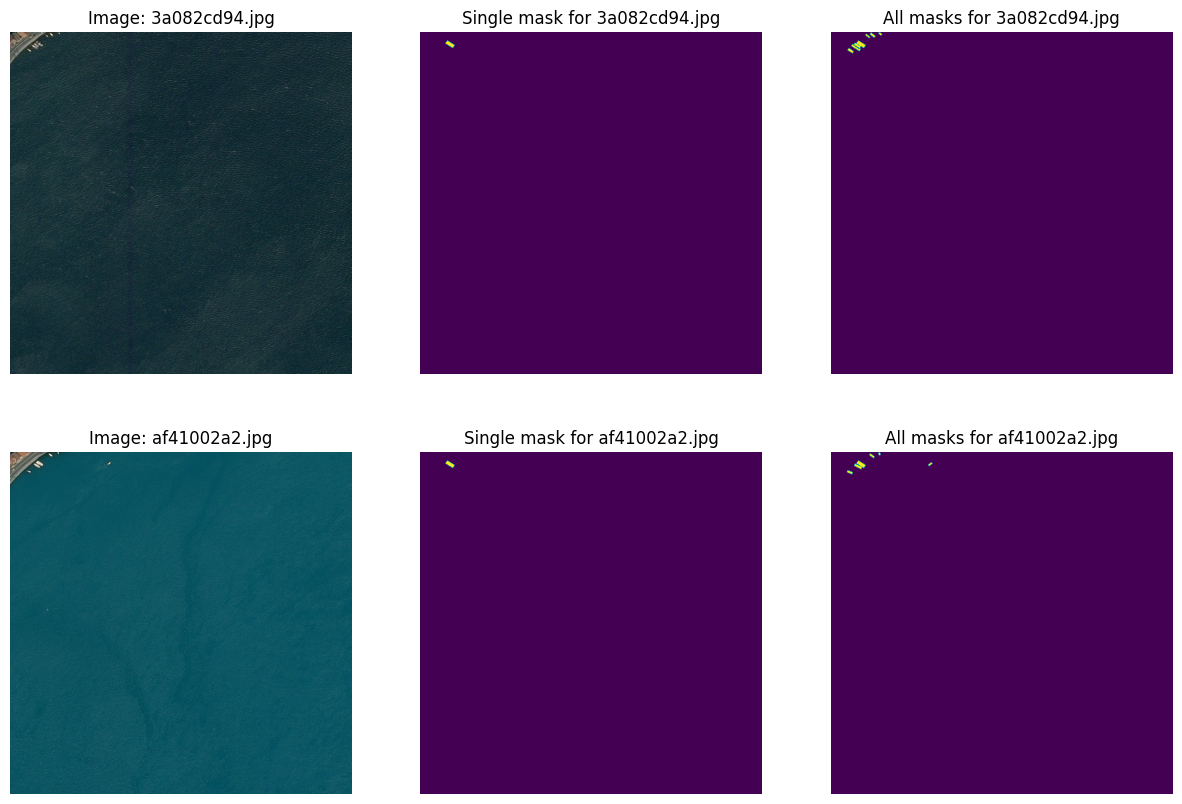

In [152]:
duplicates = df.dropna()[df.duplicated('EncodedPixels', keep=False)]
duplicates = duplicates.reset_index(drop=True)

fig, ax = plt.subplots(2,3 , figsize=(15, 10))

for i in range(len(duplicates)):
    img_name = duplicates['ImageId'].loc[i]
    img = Image.open(os.path.join(TRAIN_IMG_DIR, img_name))
    ax[i,0].imshow(img)
    width, height = img.size
    ax[i,1].imshow(create_mask(duplicates['EncodedPixels'].loc[i],width,height))
    # Read all EncodedPixels for ImageId
    masks = df.loc[df['ImageId'] == img_name , 'EncodedPixels']
    mask = np.zeros((width, height))
    for j in range(len(masks)):
        mask += create_mask(masks.iloc[j], width, height)
    ax[i, 2].imshow(mask)
    
    ax[i, 0].set_title(f'Image: {img_name}')
    ax[i, 1].set_title(f'Single mask for {img_name}')
    ax[i, 2].set_title(f'All masks for {img_name}')
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')    

We can see that the repeating EncodedPixels values are just a coincidence. These images show the same area, but they were taken at different times and have different numbers of ships in them.

Let's add a new column called "has_ship." We'll mark images with EncodedPixels as 1 and those with EncodedPixels equal to NaN as 0. Also, lets build a count plot to check the image distribution by presence of ship (repeating ImageId would be ignored as we count image number, not ship number)

Number of images with ships - 150000
Number of images withput ships - 42556
Empty to non-empty ratio - 3.5247673653538865


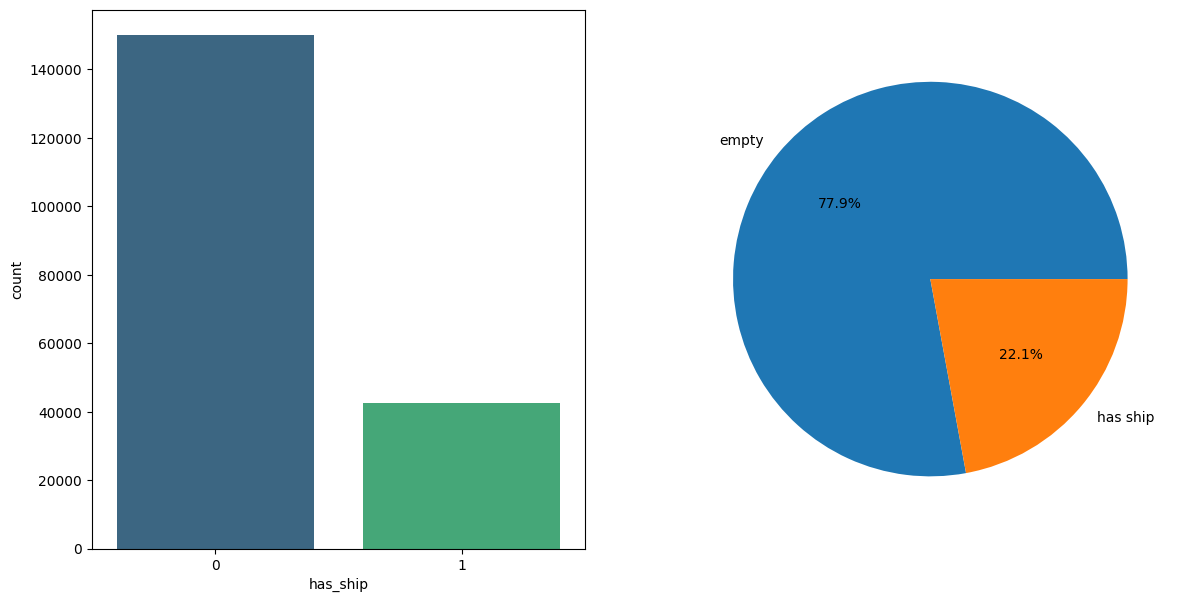

In [173]:
# Add info about ship beeing present in the image
df['has_ship'] = df['EncodedPixels'].apply(lambda x: 0 if pd.isna(x) else 1)

# Plot the chart
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

sns.countplot(x='has_ship', data=df.drop_duplicates(subset='ImageId', keep='first'), palette='viridis', ax=ax[0])

# Calculate number of empty and non empty images
num_empty = len(df[df['has_ship'] == 0])
num_non_empty = len(df.drop_duplicates(subset='ImageId', keep='first')[df['has_ship'] != 0])

ax[1].pie([num_empty, num_non_empty], labels=('empty', "has ship"), autopct='%1.1f%%')
print(f"Number of images with ships - {num_empty}")
print(f"Number of images withput ships - {num_non_empty}")
print(f"Empty to non-empty ratio - {num_empty/num_non_empty}")



As observed, the dataset is highly imbalanced, with 78% of the images being empty. Now, let's introduce a new column named 'ship_count' to show the total number of ships in each image. We'll then create a count plot of this distribution, excluding the empty images for better visual representation.

In [ ]:
df['ship_count'] = df.groupby('ImageId')['EncodedPixels'].transform('count')

fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(x='ship_count', data=df[df['ship_count'] > 0], palette='viridis', ax=ax)

# max_y = df['has_ship'].value_counts().max()
# y_ticks = np.arange(0, max_y + 1, 1)
# ax.set_yticks(y_ticks)

ax.set_xlabel('Number of ships')
ax.set_ylabel('Number of images')